In [1]:
import os
os.chdir("../")

from data_management.DataManager import CALFData, collateGCN
import numpy as np
import torch 
from Model import ContextAwareModel
from helpers.loss import ContextAwareLoss, SpottingLoss
from modules.train import trainer
import pickle
from dataclasses import dataclass
import matplotlib.pyplot as plt
from modules.GameAnalysis import GamaAnalysis
import seaborn as sns
from helpers.classes import EVENT_DICTIONARY_V2_ALIVE as event_enc
from helpers.classes import get_K_params

In [2]:
class Args:
    # DATA
    datapath="project_antwerp/football_games"
    chunk_size = 60
    batch_size = 32
    input_channel = 13
    annotation_nr = 10
    receptive_field = 12
    fps = 5
    K_parameters = get_K_params(chunk_size)
    focused_annotation = None
    generate_augmented_data = True
    class_split = "alive"
    generate_artificial_targets = False
    
    # TRAINING
    chunks_per_epoch = 1824
    lambda_coord=5.0
    lambda_noobj=0.5
    patience=25
    LR=1e-03
    max_epochs=180
    max_num_worker=1
    loglevel='INFO'
    
    # SEGMENTATION MODULE
    feature_multiplier=1
    backbone_player = "GIN"
    load_weights=None
    model_name="Testing_Model"
    dim_capsule=16
    # VLAD pooling if applicable
    vocab_size=None
    pooling=None

    # SPOTTING MODULE
    sgementation_path = None
    freeze_model = None
    spotting_fps = 1

In [3]:
args = Args
collate_fn = collateGCN

train_dataset = CALFData(split="train", args=args)
validation_dataset = CALFData(split="validate", args=args)

train_loader = torch.utils.data.DataLoader(train_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

validate_loader = torch.utils.data.DataLoader(validation_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

model = ContextAwareModel(args=args)
criterion = ContextAwareLoss(K=train_dataset.K_parameters)

optimizer = torch.optim.Adam(model.parameters(), lr=args.LR, 
                            betas=(0.9, 0.999), eps=1e-07, 
                            weight_decay=0, amsgrad=False)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=args.patience)

losses = trainer(train_loader, validate_loader,
                    model, optimizer, scheduler, 
                    criterion,
                    model_name=args.model_name,
                    max_epochs=args.max_epochs, 
                    save_dir=f"models/backbone_GIN.pth.tar")

del train_dataset, validation_dataset, train_loader, validate_loader

with open(f'results/backbone_GIN.pkl', 'wb') as file:
    pickle.dump(losses, file)

Get labels & features: 100%|██████████| 8/8 [01:08<00:00,  8.54s/it]
Train 1: Time 1.870s (it:1.662s) Data:0.805s (it:0.710s) Loss 8.7966e+00 : 100%|████████████████████████████████████████████████| 57/57 [01:46<00:00,  1.87s/it]
Evaluate 1: Time 1.231s (it:1.057s) Data:0.783s (it:0.625s) Loss 7.9366e+00 : 100%|█████████████████████████████████████████████| 57/57 [01:10<00:00,  1.23s/it]
Train 2: Time 1.813s (it:1.712s) Data:0.804s (it:0.722s) Loss 7.7809e+00 : 100%|████████████████████████████████████████████████| 57/57 [01:43<00:00,  1.81s/it]
Evaluate 2: Time 1.222s (it:4.134s) Data:0.787s (it:3.619s) Loss 6.4901e+00 : 100%|█████████████████████████████████████████████| 57/57 [01:09<00:00,  1.22s/it]
Train 3: Time 1.830s (it:1.668s) Data:0.814s (it:0.718s) Loss 7.2524e+00 : 100%|████████████████████████████████████████████████| 57/57 [01:44<00:00,  1.83s/it]
Evaluate 3: Time 1.160s (it:1.031s) Data:0.730s (it:0.635s) Loss 6.3298e+00 : 100%|███████████████████████████████████████████

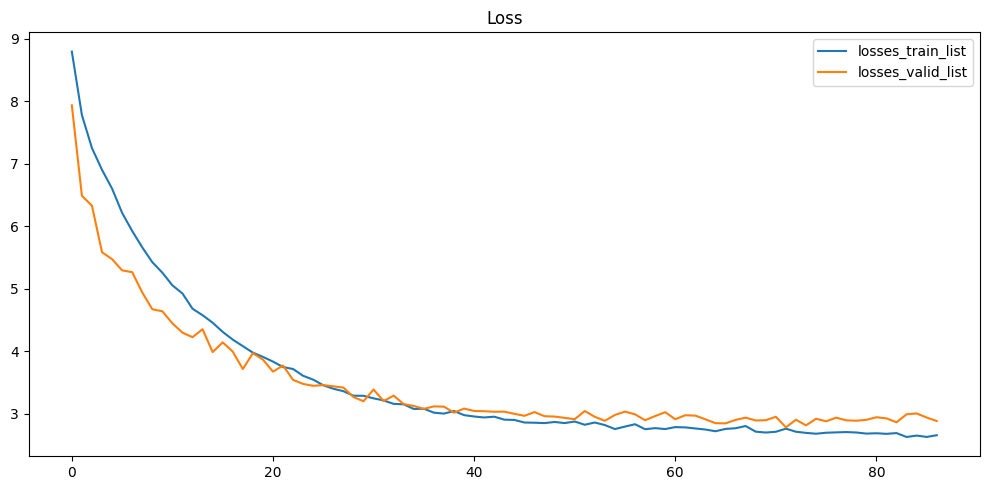

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
loss_pairs = [
    ('losses_train_list', 'losses_valid_list'), 
    ]
# Loop through each subplot

loss_pair = loss_pairs[0]
for loss in loss_pair:
    ax.plot(losses.__dict__[loss], label=loss)
    ax.set_title(loss)

# Adjust layout for better spacing
plt.tight_layout()
plt.legend()
plt.title("Loss")
# Show the plots
plt.show()

Data preprocessing: 100%|██████████| 1/1 [00:12<00:00, 12.95s/it]


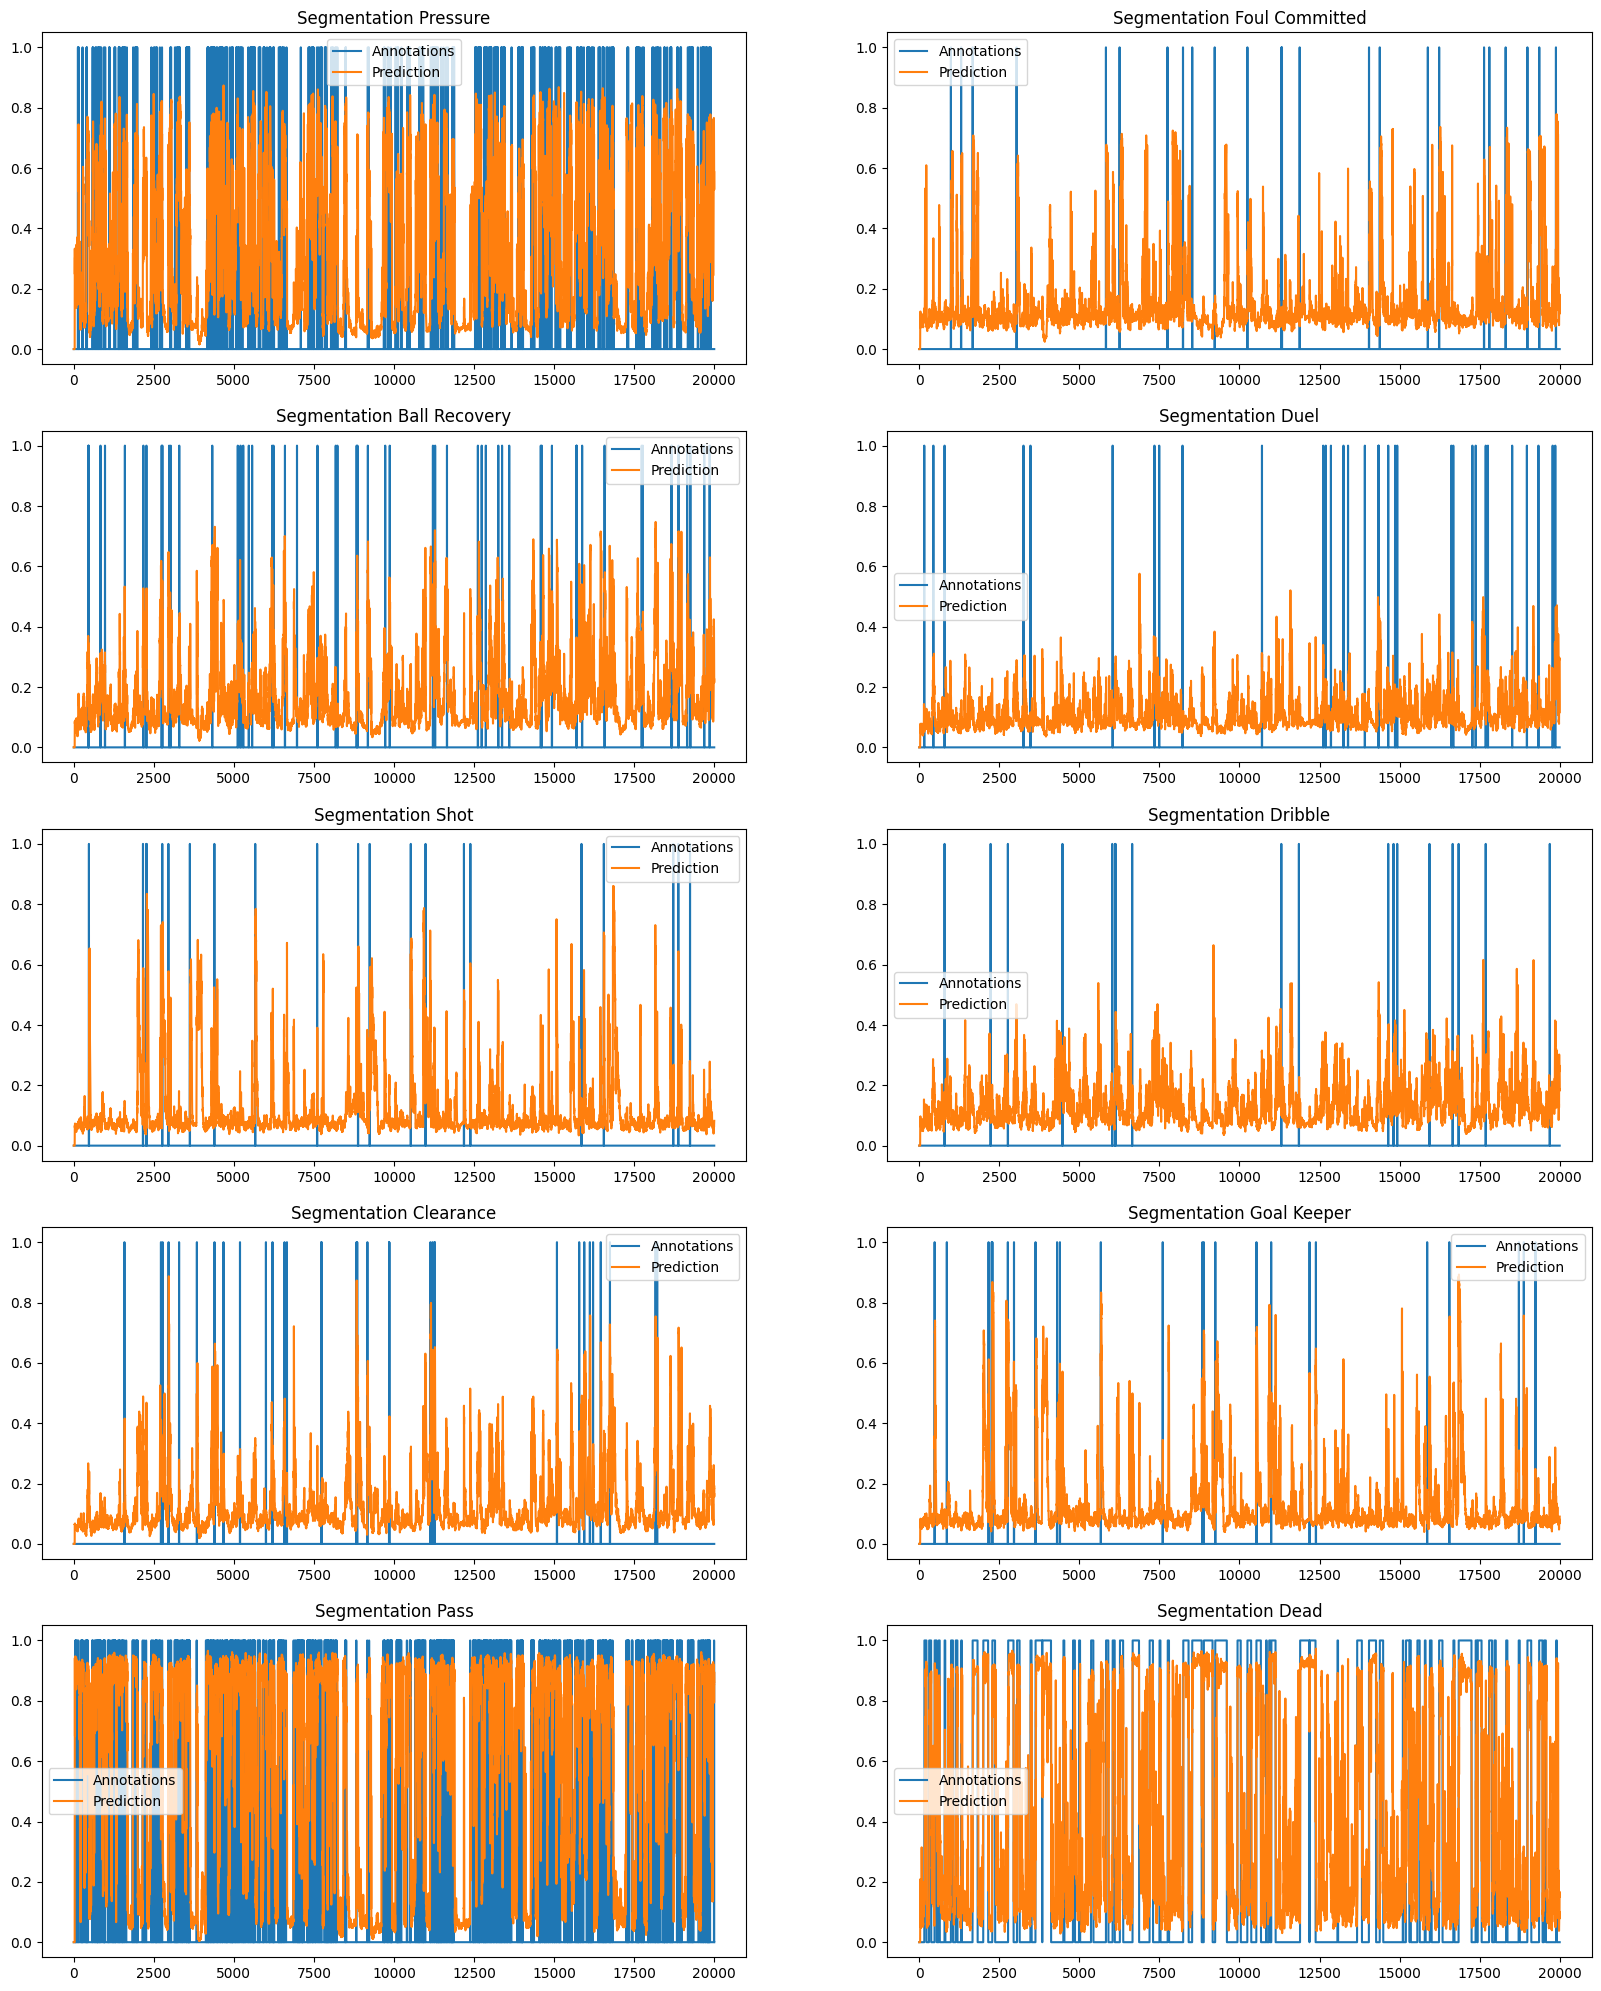

(<Figure size 2000x2500 with 10 Axes>,
 array([[<Axes: title={'center': 'Segmentation Pressure'}>,
         <Axes: title={'center': 'Segmentation Foul Committed'}>],
        [<Axes: title={'center': 'Segmentation Ball Recovery'}>,
         <Axes: title={'center': 'Segmentation Duel'}>],
        [<Axes: title={'center': 'Segmentation Shot'}>,
         <Axes: title={'center': 'Segmentation Dribble'}>],
        [<Axes: title={'center': 'Segmentation Clearance'}>,
         <Axes: title={'center': 'Segmentation Goal Keeper'}>],
        [<Axes: title={'center': 'Segmentation Pass'}>,
         <Axes: title={'center': 'Segmentation Dead'}>]], dtype=object))

In [3]:
args = Args
model_path = f"models/backbone_GIN.pth.tar"
model = torch.load(model_path)
model.eval()
game_analyser = GamaAnalysis(args, model)
results, annotations = game_analyser.predict_game(game_index=0, seg_model=True, calibrate=False, ann=None)
fig, axes = game_analyser.plot_predictions(frame_threshold=20000, save_dir=None, annotation=None)

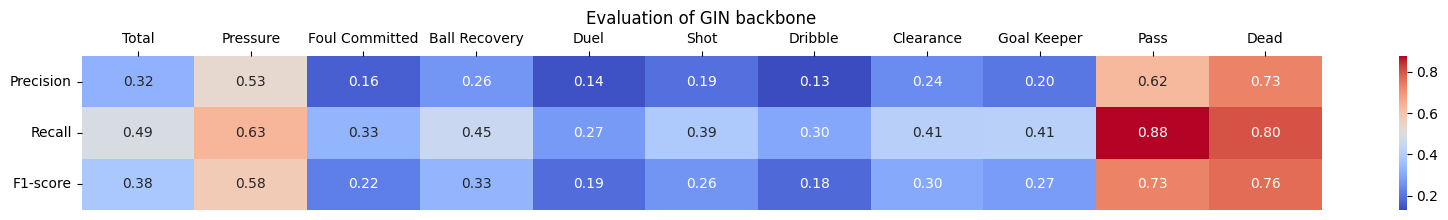

In [5]:
precision, recall, f1_score = game_analyser.segmentation_evaluation()
precision = np.concatenate((np.array([np.mean(precision)]), precision))
recall = np.concatenate((np.array([np.mean(recall)]), recall))
f1_score = np.concatenate((np.array([np.mean(f1_score)]), f1_score))

cols = ["Total"] + list(event_enc.keys())
rows = ["Precision", "Recall", "F1-score"]

fig = plt.figure(figsize=(20, 2))

total_scores = np.concatenate((precision, recall, f1_score))
# ax1.set_title("Precision scores")
ax = sns.heatmap(total_scores.reshape(3,-1), annot=True, cmap="coolwarm", fmt=".2f", xticklabels=True, yticklabels=True)
ax.set_xticklabels(cols, rotation=0)
ax.xaxis.tick_top()
ax.set_yticklabels(rows, rotation=0)

plt.title("Evaluation of GIN backbone")
plt.show()

In [7]:
total_scores.reshape(3,-1)

array([[0.32238916, 0.53014729, 0.16430021, 0.2621418 , 0.14149437,
        0.19421798, 0.13047417, 0.2427177 , 0.20489856, 0.62428457,
        0.72921497],
       [0.48713289, 0.6327551 , 0.32978109, 0.44869516, 0.27248875,
        0.3887708 , 0.29892208, 0.40827301, 0.41262755, 0.87635706,
        0.80265826],
       [0.3825742 , 0.57692444, 0.21932869, 0.33093878, 0.18626665,
        0.25903167, 0.1816579 , 0.30444393, 0.27382418, 0.72914969,
        0.76417605]])